Notebook used to experiment with the fully-connected VAE 

Aaron Choi

CMPE295 

A lot of the code was referenced from https://blog.keras.io/building-autoencoders-in-keras.html



In [ ]:
#Mount Google drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Load data
!cp drive/MyDrive/CS295/malware_data.zip .
!unzip malware_data.zip
!rm malware_data.zip
!rm -rf /content/__MACOSX

Streaming output truncated to the last 5000 lines.
  inflating: WinWebSec/fb1ef23c9dcb41e4e695b0f77006002e13397f1f.asm.txt  
  inflating: __MACOSX/WinWebSec/._fb1ef23c9dcb41e4e695b0f77006002e13397f1f.asm.txt  
  inflating: WinWebSec/fa8e99c81737f1a3f8d667bff7242f201e6b3ecb.asm.txt  
  inflating: __MACOSX/WinWebSec/._fa8e99c81737f1a3f8d667bff7242f201e6b3ecb.asm.txt  
  inflating: WinWebSec/1afc2a2036812279c58de0b825ebdea423341182.asm.txt  
  inflating: __MACOSX/WinWebSec/._1afc2a2036812279c58de0b825ebdea423341182.asm.txt  
  inflating: WinWebSec/535f05c124a21b5d1746ac7c1d36ed7df3eeb260.asm.txt  
  inflating: __MACOSX/WinWebSec/._535f05c124a21b5d1746ac7c1d36ed7df3eeb260.asm.txt  
  inflating: WinWebSec/b77d8d8fc75ecf193af4e90ab559bc54f2bd38b6.asm.txt  
  inflating: __MACOSX/WinWebSec/._b77d8d8fc75ecf193af4e90ab559bc54f2bd38b6.asm.txt  
  inflating: WinWebSec/008883bab2c8e1f32d03707abd5dc7650c813615.asm.txt  
  inflating: __MACOSX/WinWebSec/._008883bab2c8e1f32d03707abd5dc7650c813615.asm.t

In [ ]:
### Load the mnemonic opcode to integer mappings ###

!cp drive/MyDrive/CS295/data.py .
!cp drive/MyDrive/CS295/opdictWinWebSec.json .
!cp drive/MyDrive/CS295/opdictZbot.json .
!cp drive/MyDrive/CS295/opdictVBInject.json .
!cp drive/MyDrive/CS295/opdictOnLineGames.json .
!cp drive/MyDrive/CS295/opdictRenos.json .
!cp drive/MyDrive/CS295/opdictAllFiveFamilies.json .

In [ ]:
!mkdir /content/AllFiveFamilies
!ln -s /content/OnLineGames/* /content/AllFiveFamilies
!ln -s /content/Renos/* /content/AllFiveFamilies
!ln -s /content/VBInject/* /content/AllFiveFamilies
!ln -s /content/WinWebSec/* /content/AllFiveFamilies
!ln -s /content/Zbot/* /content/AllFiveFamilies

In [ ]:
import os
import sys
import glob
import matplotlib 
import matplotlib.pyplot as plt
import json

import numpy as np
import data 
import graphviz 
import plotly
import plotly.express as px 
import pandas as pd
import tensorflow as tf
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.layers import Add, Input, Dense, Reshape, Flatten, Conv1D
from tensorflow.keras.layers import BatchNormalization, Activation, Lambda
from tensorflow.keras.layers import LeakyReLU, LayerNormalization
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model 
from keras import backend as K 

# Tensorflow / Keras
from keras.models import Model 

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tensorflow.compat.v1.logging.set_verbosity(tensorflow.compat.v1.logging.ERROR)
from tensorflow.keras.optimizers.experimental import Adadelta, Adagrad, Adamax 
from tensorflow.keras.optimizers.experimental import Ftrl, Nadam, RMSprop, SGD
from tensorflow.keras.optimizers.experimental import Adam, AdamW
from tensorflow.keras.optimizers.legacy import RMSprop, Adam

# Assign main directory to a variable
#main_dir=os.path.dirname(sys.path[0])

In [ ]:
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import OPTICS, DBSCAN
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.metrics import confusion_matrix, recall_score, precision_score

from sklearn.preprocessing import StandardScaler
from sklearn import datasets


In [ ]:
files = glob.glob('Renos/*.txt')
print(len(files))

1568


In [ ]:
#family = ['WinWebSec', 'Zbot', 'VBInject', 'OnLineGames', 'Renos']
family = ['WinWebSec']
#family = ['AllFiveFamilies']
for fam in family:
  initial = 0
  data_obj= data.DATA(fam, 600)
  data_samples_0, num_unique_0 = data_obj.load_data(True)
  print('Num unique: %d'%num_unique_0)
  print('Total Valid: ', len(data_samples_0))


Total samples for WinWebSec: 4360
Mappings in JSON file: 21
Num unique: 21
Total Valid:  3932


In [ ]:
y_train_1 = np.ones(len(data_samples_0))
X_train_norm = data_samples_0/num_unique_0
X_train = X_train_norm
print(len(X_train))
print(len(y_train_1))

3932
3932


In [ ]:
#Most of code was referenced from the Kera's blog
#https://blog.keras.io/building-autoencoders-in-keras.html

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_sigma) * epsilon

In [ ]:
original_dim = 600 
latent_dim = 2
#Create encoder
#Input Layer 
visible = keras.Input(shape=(original_dim,), name='Encoder-Input-Layer')

#Hidden Layer
h_enc1 = Dense(units=256, activation='relu', name='Encoder-Hidden-Layer-1')(visible)
h_enc2 = Dense(units=128, activation='relu', name='Encoder-Hidden-Layer-2')(h_enc1)
h_enc3 = Dense(units=64, activation='relu', name='Encoder-Hidden-Layer-3')(h_enc2)
h_enc4 = Dense(units=32, activation='relu', name='Encoder-Hidden-Layer-4')(h_enc3)
h_enc5 = Dense(units=16, activation='relu', name='Encoder-Hidden-Layer-5')(h_enc4)

#Custom Latent Space Layer
z_mean = Dense(units=latent_dim, name='Z-Mean')(h_enc5) # Mean component
z_log_var = Dense(units=latent_dim, name='Z-Log-Var')(h_enc5) # Standard deviation component
z = Lambda(sampling, name='Z-Sampling-Layer')([z_mean, z_log_var]) # Z sampling layer

#Create Encoder model
encoder = Model(visible, [z_mean, z_log_var, z], name='Encoder-Model')

#Display model diagram
#plot_model(encoder, show_shapes=True, dpi=300)
encoder.summary()


# ********** Create Decoder **********

#Input Layer 
latent_inputs = Input(shape=(latent_dim,), name='Input-Z-Sampling')

#Hidden Layer
h_dec = Dense(units=16, activation='relu', name='Decoder-Hidden-Layer-1')(latent_inputs)
h_dec2 = Dense(units=32, activation='relu', name='Decoder-Hidden-Layer-2')(h_dec)
h_dec3 = Dense(units=64, activation='relu', name='Decoder-Hidden-Layer-3')(h_dec2)
h_dec4 = Dense(units=128, activation='relu', name='Decoder-Hidden-Layer-4')(h_dec3)
h_dec5 = Dense(units=256, activation='relu', name='Decoder-Hidden-Layer-5')(h_dec4)

#Output Layer
outputs = Dense(original_dim, activation='sigmoid', name='Decoder-Output-Layer')(h_dec5)

#Create Decoder model
decoder = Model(latent_inputs, outputs, name='Decoder-Model')

#Display model diagram
plot_model(decoder, show_shapes=True, dpi=300)
decoder.summary()

Model: "Encoder-Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Encoder-Input-Layer (InputLaye  [(None, 600)]       0           []                               
 r)                                                                                               
                                                                                                  
 Encoder-Hidden-Layer-1 (Dense)  (None, 256)         153856      ['Encoder-Input-Layer[0][0]']    
                                                                                                  
 Encoder-Hidden-Layer-2 (Dense)  (None, 128)         32896       ['Encoder-Hidden-Layer-1[0][0]'] 
                                                                                                  
 Encoder-Hidden-Layer-3 (Dense)  (None, 64)          8256        ['Encoder-Hidden-Laye

In [ ]:


outpt = decoder(encoder(visible)[2]) 

vae = Model(inputs=visible, outputs=outpt, name='VAE-Model')
vae.summary()
reconstruction_loss = keras.losses.binary_crossentropy(visible, outpt)
#reconstruction_loss = keras.losses.mse(visible, outpt)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer=tf.keras.optimizers.experimental.AdamW(learning_rate=0.001,weight_decay=0.004,beta_1=0.9,beta_2=0.999,epsilon=1e-07))
#vae.compile(optimizer=tf.keras.optimizers.experimental.Adadelta(learning_rate=0.001,rho=0.95,epsilon=1e-07))
#vae.compile(optimizer=tf.keras.optimizers.experimental.Adagrad(learning_rate=0.001,initial_accumulator_value=0.1,epsilon=1e-07))
#vae.compile(optimizer=tf.keras.optimizers.experimental.Adamax(learning_rate=0.001, beta_1=0.9,beta_2=0.999,epsilon=1e-07))
#vae.compile(optimizer=tf.keras.optimizers.experimental.Ftrl(learning_rate=0.001,learning_rate_power=-0.5))
#vae.compile(optimizer=tf.keras.optimizers.experimental.Nadam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-07,))
#vae.compile(optimizer=tf.keras.optimizers.experimental.RMSprop(learning_rate=0.001,rho=0.9,momentum=0.0,epsilon=1e-07))
#vae.compile(optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=0.001,momentum=0.0))
#vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-07))


Model: "VAE-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder-Input-Layer (InputL  [(None, 600)]            0         
 ayer)                                                           
                                                                 
 Encoder-Model (Functional)  [(None, 2),               197684    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 Decoder-Model (Functional)  (None, 600)               198248    
                                                                 
Total params: 395,932
Trainable params: 395,932
Non-trainable params: 0
_________________________________________________________________


Epoch 1/30
246/246 [==============================] - 4s 8ms/step - loss: 301.2930
Epoch 2/30
246/246 [==============================] - 3s 11ms/step - loss: 286.9514
Epoch 3/30
246/246 [==============================] - 2s 7ms/step - loss: 283.6498
Epoch 4/30
246/246 [==============================] - 2s 7ms/step - loss: 280.7644
Epoch 5/30
246/246 [==============================] - 2s 7ms/step - loss: 279.0451
Epoch 6/30
246/246 [==============================] - 2s 7ms/step - loss: 277.9629
Epoch 7/30
246/246 [==============================] - 2s 7ms/step - loss: 277.2750
Epoch 8/30
246/246 [==============================] - 2s 8ms/step - loss: 276.4643
Epoch 9/30
246/246 [==============================] - 3s 11ms/step - loss: 275.4843
Epoch 10/30
246/246 [==============================] - 2s 7ms/step - loss: 274.9026
Epoch 11/30
246/246 [==============================] - 2s 7ms/step - loss: 274.1355
Epoch 12/30
246/246 [==============================] - 2s 7ms/step - loss: 275.0545

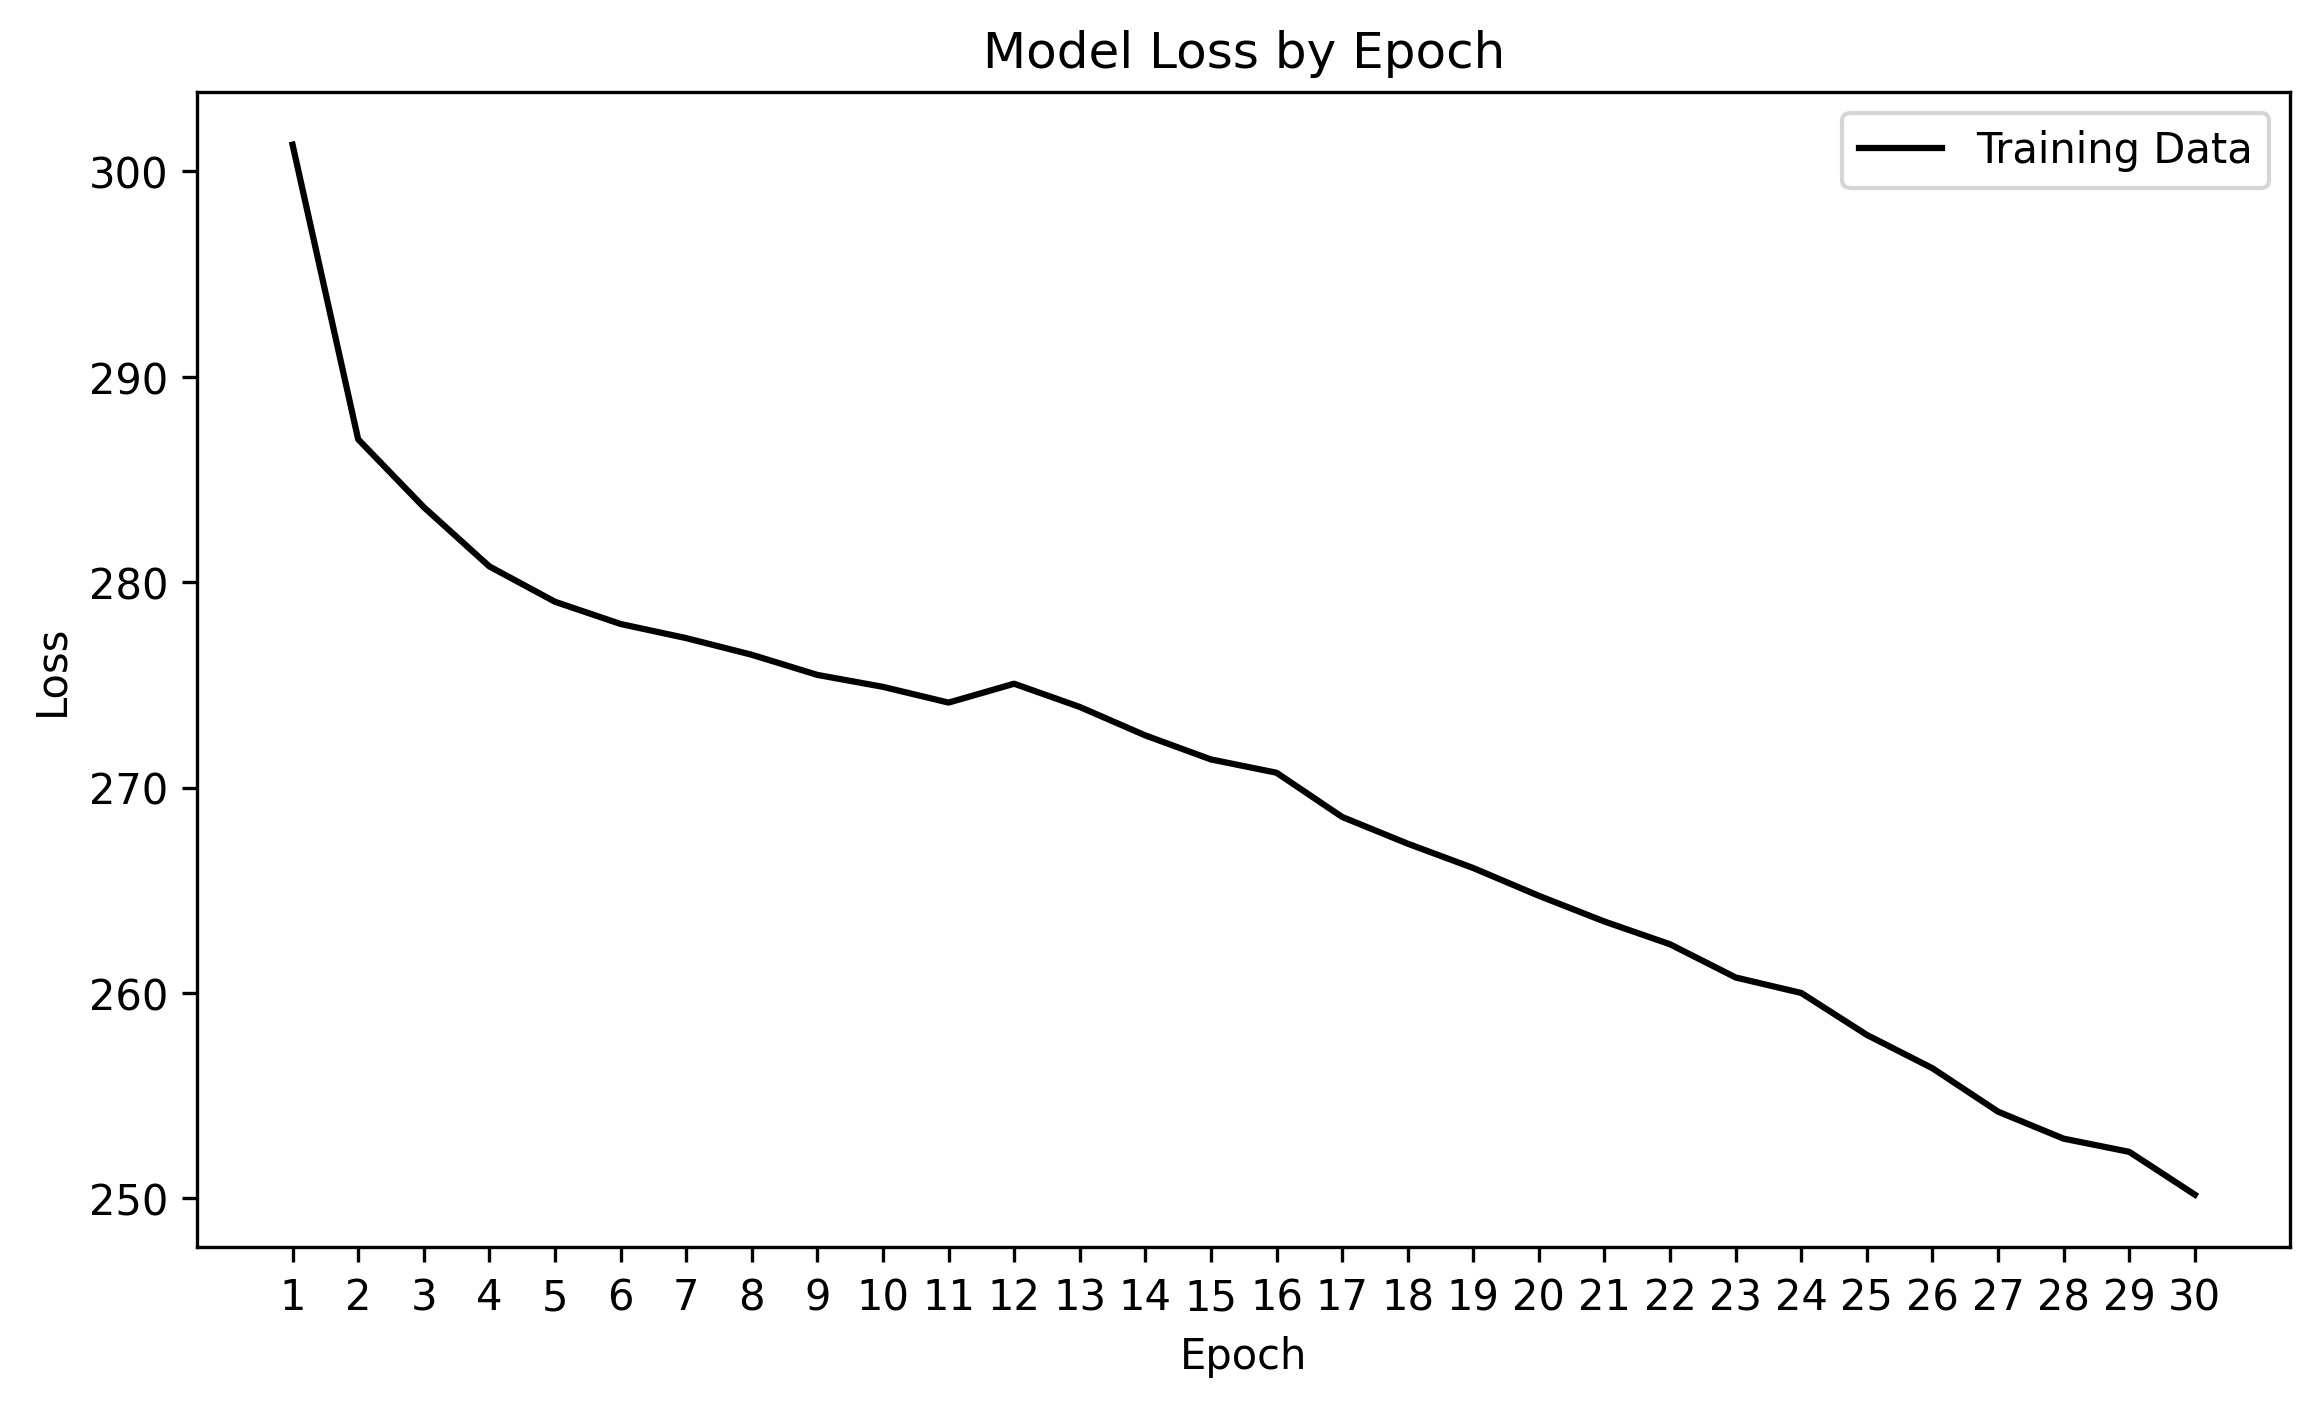

In [ ]:
history = vae.fit(X_train, epochs=30, batch_size = 16)
fig, ax = plt.subplots(figsize=(9,5), dpi=300)
plt.title(label='Model Loss by Epoch', loc='center')
ax.plot(history.history['loss'], label='Training Data', color='black')
ax.set(xlabel='Epoch', ylabel='Loss')
plt.xticks(ticks=np.arange(len(history.history['loss']), step=1), labels=np.arange(1, len(history.history['loss'])+1, step=1))
plt.legend()
plt.show()



In [ ]:

X_train_encoded = encoder.predict(X_train)
fig = px.scatter(None, x=X_train_encoded[2][:,0], y=X_train_encoded[2][:,1], 
                 opacity=1, color=y_train_1.astype(str), width=800, height=400)

fig.update_layout(dict(plot_bgcolor = 'white'))

# Update axes lines
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='white', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='white', 
                 showline=True, linewidth=1, linecolor='white',
                 title_font=dict(size=10), tickfont=dict(size=10))

fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='white', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='white', 
                 showline=True, linewidth=1, linecolor='white',
                 title_font=dict(size=10), tickfont=dict(size=10))

# Set figure title
fig.update_layout(title_text="2D Latent Space")
# Update marker size
fig.update_traces(marker=dict(size=2))
fig.show()
#history.history['loss']
a=history.history['loss']


123/123 [==============================] - 0s 2ms/step


In [ ]:
x=X_train_encoded[2][:,0]
y=X_train_encoded[2][:,1]
xy_points = np.array((x,y)).T

In [ ]:
print(len(x))
print(len(y))
print(x[0])
print(len(xy_points))


3932
3932
-1.3851593
3932


Now experimented with clustering of the latent space

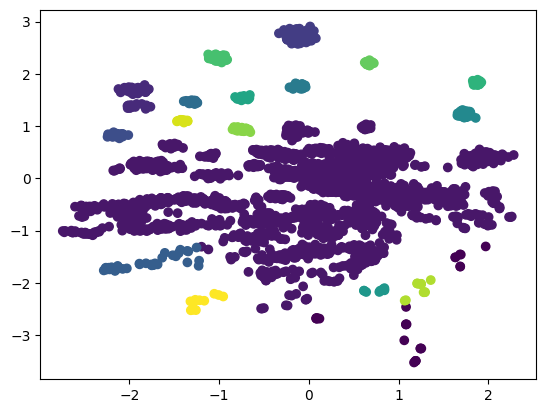

In [ ]:
X = StandardScaler().fit_transform(xy_points)
clustermodel = DBSCAN(eps=0.3,min_samples=10)

y_pred = DBSCAN(eps=0.3, min_samples=10).fit_predict(X)
plt.scatter(X[:,0], X[:,1], c=y_pred)

In [ ]:
print(len(y_pred))

3932


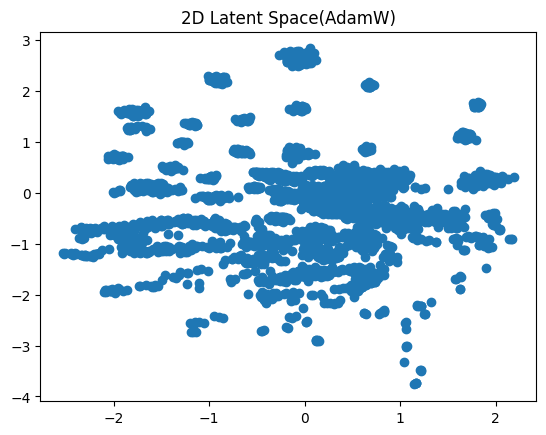

In [ ]:
plt.scatter(x,y)
plt.title('2D Latent Space(AdamW)')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



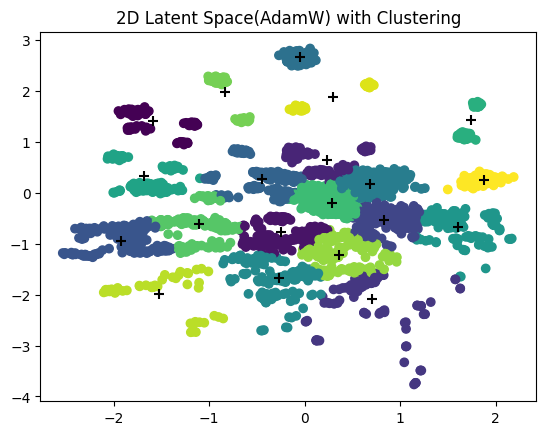

In [ ]:
n_clusters = 20
kmeans = KMeans(n_clusters = n_clusters)
kmeans.fit(xy_points)
plt.scatter(x,y,c=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],s = 50, c = 'k',marker = '+')
plt.title('2D Latent Space(AdamW) with Clustering')
plt.show()

In [ ]:
optics_cluster = OPTICS(min_samples = 10, xi=.03, min_cluster_size = 0.02)
optics_cluster.fit(xy_points)

OPTICS(min_cluster_size=0.02, min_samples=10, xi=0.03)

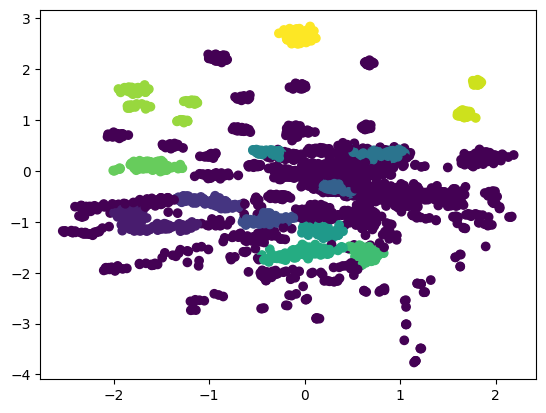

In [ ]:
plt.scatter(x,y,c=optics_cluster.labels_)
plt.show()

In [ ]:
#Saving the loss arrays to comparison 
# Adadelta_loss = np.load('Adadelta_loss.npy')
# Adagrad_loss = np.load('Adagrad_loss.npy')
# Adamax_loss = np.load('Adamax_loss.npy')
# Ftrl_loss = np.load('Ftrl_loss.npy')
# Nadam_loss = np.load('Nadam_loss.npy')
# RMSProp_loss = np.load('RMSProp_loss.npy')
# SGD_loss = np.load('SGD_loss.npy')
# Adam_loss = np.load('Adam_loss.npy')
# AdamW_loss = np.load('AdamW_loss.npy')

# x_axis = list(range(1,31))
# plt.figure(figsize=(10,6))
# plt.plot(x_axis, Adadelta_loss, label = 'Adadelta Loss', color='k' )
# plt.plot(x_axis, Adagrad_loss, label = 'Adagrad Loss', color='y' )
# plt.plot(x_axis, Adamax_loss, label = 'Adamax Loss', color='y' )
# plt.plot(x_axis, AdamW_loss, label = 'AdamW Loss', color='b' )
# plt.plot(x_axis, Ftrl_loss, label = 'Ftrl Loss', color='c' )
# plt.plot(x_axis, Nadam_loss, label = 'Nadam Loss', color='g' )
# plt.plot(x_axis, SGD_loss, label = 'SGD Loss', color='m' )
# plt.plot(x_axis, RMSProp_loss, label = 'RMSProp Loss', color='r' )

# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Optimizer Loss')
# plt.legend()
# plt.show()


Testing out the output 

In [ ]:
#Regular normal distribution in latent space
noise = tf.random.normal(shape=(100,latent_dim))


In [ ]:
digit_decoded = decoder.predict(noise)

4/4 [==============================] - 0s 3ms/step


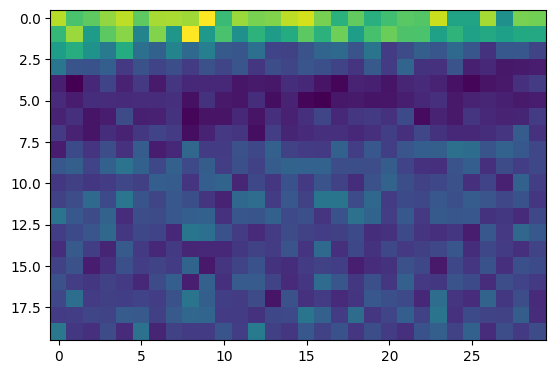

In [ ]:
gen = digit_decoded[10] 
gen_img = np.reshape(gen, (20, 30))
gen_img_250 = gen_img
plt.imshow(gen_img_250) 

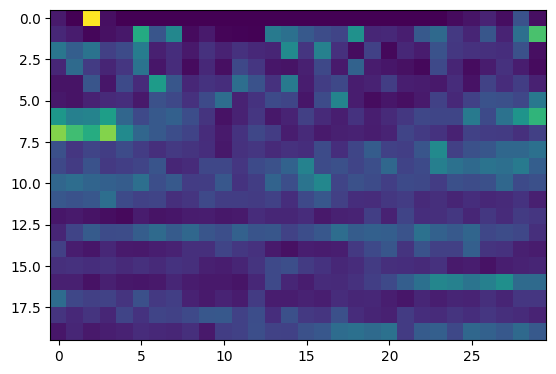

In [ ]:
gen = digit_decoded[50] 
gen_img = np.reshape(gen, (20, 30))
gen_img_250 = gen_img
plt.imshow(gen_img_250) 

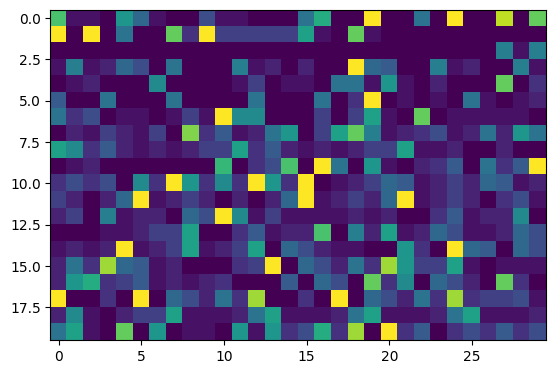

In [ ]:
#Looking at authentic malware
first_ex = X_train[2]
first_ex_img = np.reshape(first_ex, (20, 30))
first_ex_img_250 = first_ex_img 
plt.imshow(first_ex_img_250)

<class 'list'>
1/1 [==============================] - 0s 30ms/step


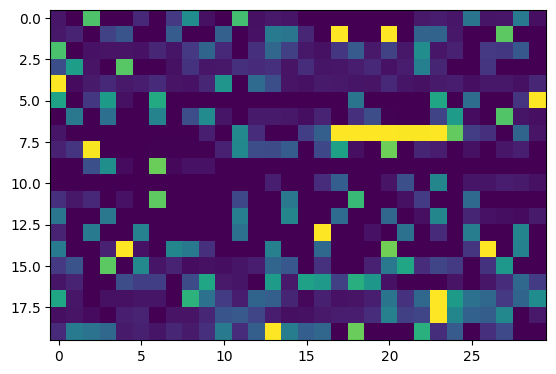

In [ ]:
#Experiment 
#Selecting the cluster with the smallest sse 

cluster_centers = [xy_points[kmeans.labels_ == i].mean(axis=0) for i in range(n_clusters)]
#print(cluster_centers)
clusterwise_sse = np.zeros(n_clusters)
for point, label in zip(X, kmeans.labels_):
    clusterwise_sse[label] += np.square(point - cluster_centers[label]).sum()
#print(clusterwise_sse)
#print(clusterwise_sse[15])
min_index = clusterwise_sse.argmin()
cluster_smallestsse_center = cluster_centers[min_index]
#print(cluster_smallestsse_center)
#print(cluster_smallestsse_center)
small_sse = cluster_smallestsse_center.tolist()
cluster_center_ex = [small_sse]
print(type(cluster_center_ex))
digit_decoded_cc_ex = decoder.predict(cluster_center_ex )
gen1 = digit_decoded_cc_ex[0] 
gen_img1 = np.reshape(gen1, (20, 30))
plt.imshow(gen_img1) 

In [ ]:
##noise_cluster = tf.random.normal(shape=(11335,latent_dim), mean=cluster_smallestsse_center[0], stddev =cluster_smallestsse_center [1])
#noise_cluster = tf.random.normal(shape=(len(data_samples_0),latent_dim), mean=cluster_smallestsse_center[0], stddev =cluster_smallestsse_center[1])
noise_cluster = tf.random.normal(shape=(100,latent_dim), mean=cluster_smallestsse_center[0], stddev =cluster_smallestsse_center[1])

#noise
#num_samples = len(noise_cluster)
#print(num_samples)
digit_decoded_cc_ex = decoder.predict(noise_cluster)
smaller_cluster_int = digit_decoded_cc_ex * num_unique_0
#print(smaller_cluster_int)
generated_sample_full = np.rint(smaller_cluster_int)

4/4 [==============================] - 0s 3ms/step


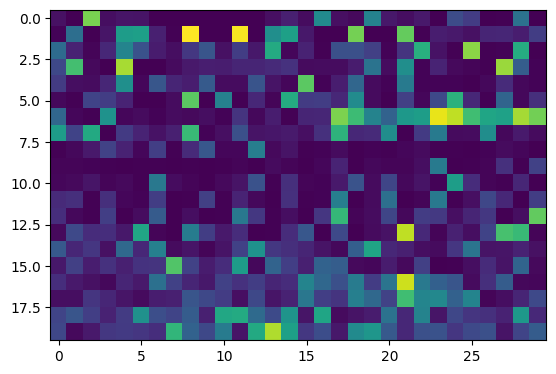

In [ ]:

gen1 = digit_decoded_cc_ex[9] 
gen_img1 = np.reshape(gen1, (20, 30))
plt.imshow(gen_img1) 

In [ ]:
#used for all malware families 
# num_samples = len(decode2)
# print(num_samples)
# gen_samples = np.reshape(decode2, (11335, 600))
# gen_samples = gen_samples*num_unique_0
# gen_samples = np.rint(gen_samples)
# gen_samples = gen_samples.astype(int)
# gen_samples = np.clip(gen_samples, 0, num_unique_0)

# fname = "FC_VAE" + str(fam) + "_" 
# np.save(fname, gen_samples)